In [3]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt
# from interactions import traverse_all_paths, apply_rule, make_line, make_grid
from itertools import combinations_with_replacement
# from sklearn.ensemble.partial_dependence import plot_partial_dependence
# from sklearn.ensemble.partial_dependence import partial_dependence

In [9]:
bikes_daily = np.genfromtxt('../data/Bike-Sharing-Dataset/day.csv', delimiter=",")
X = bikes_daily[:, 2:13]
Y = bikes_daily[:, 15:]
labels = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'humidity', 'windspeed']
no_nans = np.any(np.isnan(X), axis=1)
X = X[~no_nans]
Y = Y[~no_nans]
print("X shape", X.shape)
print("Y shape", Y.shape)
train_mask = np.random.choice(np.arange(0, 731), 550)
test_mask = np.random.choice(np.arange(0, 731), 250)
X_train = X[train_mask, :]
Y_train = np.reshape(Y[train_mask, :], (550,))
X_test = X[test_mask, :]
Y_test = np.reshape(Y[test_mask, :], (250,))
print("X shape", X.shape)
print("Y shape", Y.shape)
print("training X shape", X_train.shape)
print("training Y shape", Y_train.shape)
print("testing X shape", X_test.shape)
print("testing Y shape", Y_test.shape)
print(np.mean(Y_train))

X shape (731, 11)
Y shape (731, 1)
X shape (731, 11)
Y shape (731, 1)
training X shape (550, 11)
training Y shape (550,)
testing X shape (250, 11)
testing Y shape (250,)
4382.830909090909


In [3]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
preds = model.predict(X_test)
print(preds.shape)
print(Y_test.shape)
accuracy = np.linalg.norm(Y_test - preds)
print("Model loss:", accuracy)

(250,)
(250,)
Model loss: 7126.923438419975


In [4]:
#MEAN DECREASE IN IMPURITY
#features are 
imp_scores = model.feature_importances_
for i in range(len(imp_scores)):
    print("Impurity Score", imp_scores[i], "for feature", labels[i])

Impurity Score 0.04699755459869702 for feature season
Impurity Score 0.2750966544862088 for feature year
Impurity Score 0.03166691097157006 for feature month
Impurity Score 0.0026753607526965374 for feature holiday
Impurity Score 0.013359603818212192 for feature weekday
Impurity Score 0.0029796957119804447 for feature workingday
Impurity Score 0.020628419286639756 for feature weathersit
Impurity Score 0.1787354019743436 for feature temp
Impurity Score 0.31110840705830795 for feature atemp
Impurity Score 0.08430887647420918 for feature humidity
Impurity Score 0.0324431148671344 for feature windspeed


In [5]:
def single_var_plt(forest, X, y, S, rng, step, feat_name, numtrees):
    models = forest.estimators_
    length = (rng[1] - rng[0])/(1.0 * step)
    line = np.zeros(int(length))
    index = np.nonzero(S)[0][0]
    num_vars = len(S)
    for model in models:
        vals = traverse_all_paths(model, X, y, S, continuous_y=True)
        line += make_line(vals, rng, step, S)
    line = line/(numtrees * 1.0)
    x_axis = np.arange(rng[0], rng[1], step)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, line, 'k', c='b', label=feat_name)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.show()

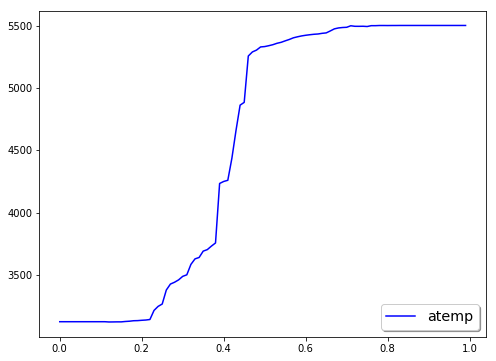

In [6]:
S_atemp = np.zeros(11)
S_atemp[8] = 1
single_var_plt(model, X_train, Y_train, S_atemp, (0, 1), .01, "atemp", 100)

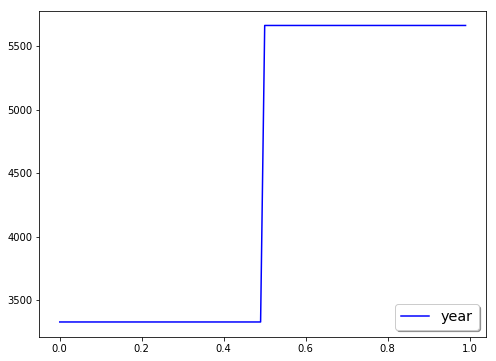

In [7]:
S_year = np.zeros(11)
S_year[1] = 1
single_var_plt(model, X_train, Y_train, S_year, (0, 1), .01, "year", 100)

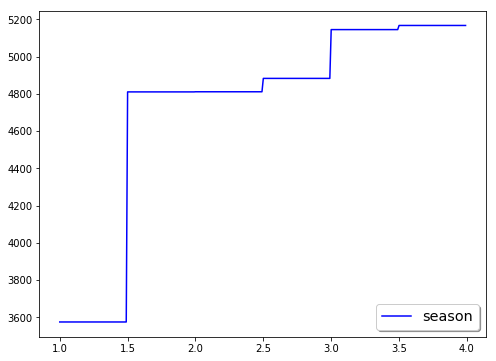

In [24]:
S_season = np.zeros(11)
S_season[0] = 1
single_var_plt(model, X_train, Y_train, S_season, (1, 4), .01, "season", 100)

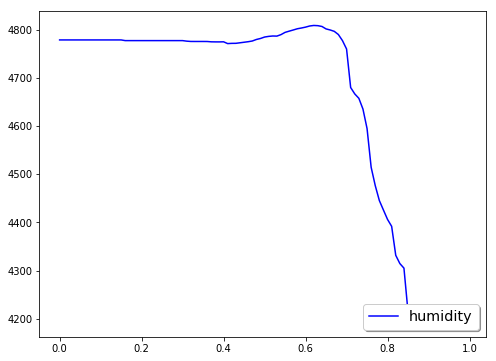

In [9]:
S_hum = np.zeros(11)
S_hum[9] = 1
single_var_plt(model, X_train, Y_train, S_hum, (0, 1), .01, "humidity", 100)

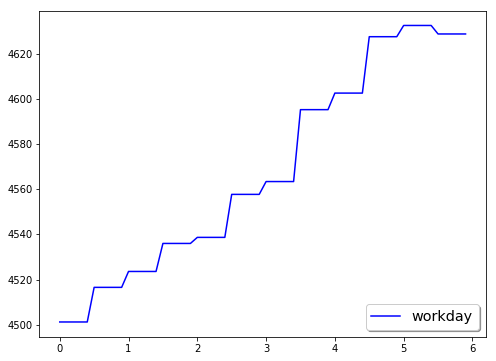

In [10]:
S_workday = np.zeros(11)
S_workday[4] = 1
single_var_plt(model, X_train, Y_train, S_workday, (0, 6), .1, "workday", 100)

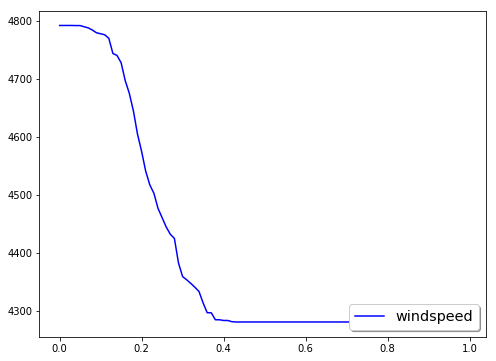

In [11]:
S_wind = np.zeros(11)
S_wind[10] = 1
single_var_plt(model, X_train, Y_train, S_wind, (0, 1), .01, "windspeed", 100)

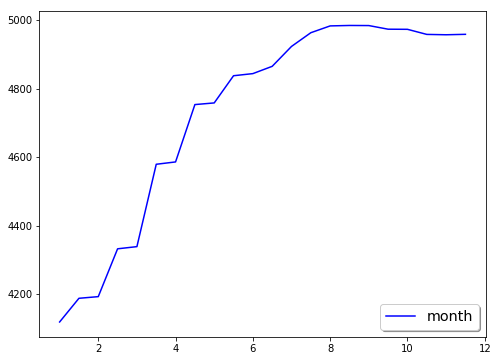

In [32]:
S_month = np.zeros(11)
S_month[2] = 1
single_var_plt(model, X_train, Y_train, S_month, (1, 12), .5, "month", 100)

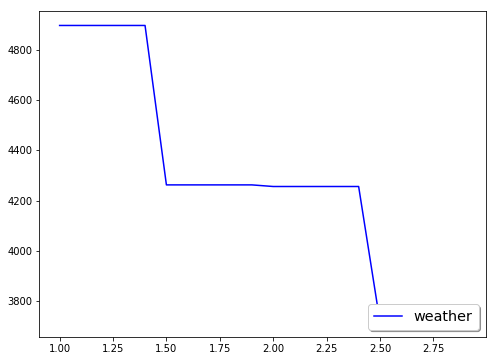

In [12]:
S_weather = np.zeros(11)
S_weather[6] = 1
single_var_plt(model, X_train, Y_train, S_weather, (1, 3), .1, "weather", 100)

In [13]:
def two_var_plt(forest, X, y, S, x_rng, y_rng, x_step, y_step, x_ticks, y_ticks, feat_name, numtrees):
    models = forest.estimators_
    num_vars = len(S)
    grid = 0
    for model in models:
        vals = traverse_all_paths(model, X, y, S, continuous_y=True)
        grid += make_grid(vals, x_rng, y_rng, x_step, y_step, S)
    grid = grid/(numtrees * 1.0)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    im = ax.imshow(grid)
    cbar_kw = {}
    cbarlabel = feat_name
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    x_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
    y_length = (x_rng[1] - x_rng[0])/(1.0 * x_step)
    ax.set_xticks(x_ticks[0])
    ax.set_yticks(y_ticks[0])
    ax.set_xticklabels(x_ticks[1])
    ax.set_yticklabels(y_ticks[1])
    plt.show()

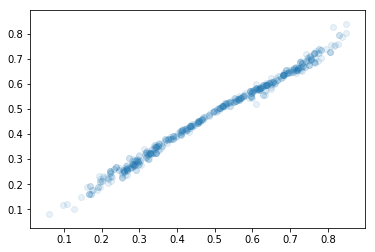

4562.961818181818


In [29]:
temp = X_train[:, 7]
atemp = X_train[:, 8]
plt.scatter(temp, atemp, alpha=.1)
plt.show()
print(np.mean(Y_train))

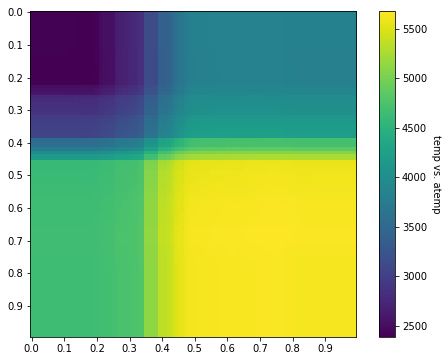

In [16]:
S_temps = np.zeros(11)
S_temps[7] = 1
S_temps[8] = 1
x_range = np.arange(0, 100, 10)
x_labels = np.round(np.arange(0, 1, .1), 2)
x_ticks = (x_range, x_labels)
two_var_plt(model, X_train, Y_train, S_temps, (0, 1), (0, 1), .01, .01, x_ticks, x_ticks, "temp vs. atemp", 100)

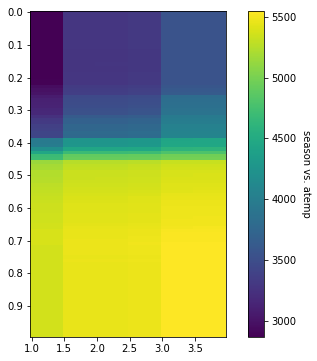

In [19]:
S_atemp_seas = np.zeros(11)
S_atemp_seas[0] = 1
S_atemp_seas[8] = 1
x_range = np.arange(0, 60, 10)
x_labels = np.round(np.arange(1, 4, .5), 2)
x_ticks = (x_range, x_labels)
y_range = np.arange(0, 100, 10)
y_labels = np.round(np.arange(0, 1, .1), 2)
y_ticks = (y_range, y_labels)
two_var_plt(model, X_train, Y_train, S_atemp_seas, (1, 4), (0, 1), .05, .01, x_ticks, y_ticks, "season vs. atemp", 100)

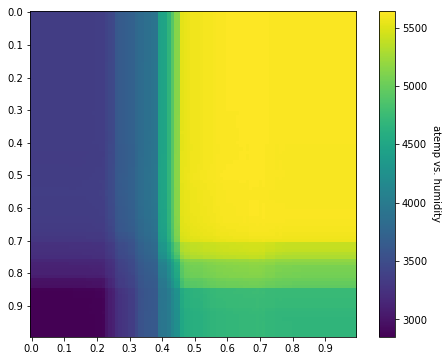

In [20]:
S_atemp_hum = np.zeros(11)
S_atemp_hum[8] = 1
S_atemp_hum[9] = 1
x_range = np.arange(0, 100, 10)
x_labels = np.round(np.arange(0, 1, .1), 2)
x_ticks = (x_range, x_labels)
two_var_plt(model, X_train, Y_train, S_atemp_hum, (0, 1), (0, 1), .01, .01, x_ticks, x_ticks, "atemp vs. humidity", 100)

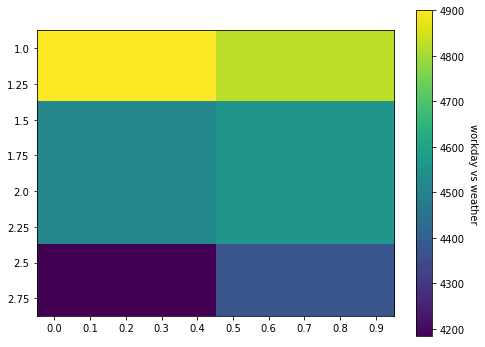

In [41]:
S_work_weath = np.zeros(11)
S_work_weath[5] = 1
S_work_weath[6] = 1
x_range = np.arange(0, 10, 1)
x_labels = np.round(np.arange(0, 1, .1), 2)
x_ticks = (x_range, x_labels)
y_range = np.arange(0, 8, 1)
y_labels = np.round(np.arange(1, 3, .25), 2)
y_ticks = (y_range, y_labels)
two_var_plt(model, X_train, Y_train, S_work_weath, (0, 1), (1, 3), .1, .25, x_ticks, y_ticks, "workday vs weather", 100)

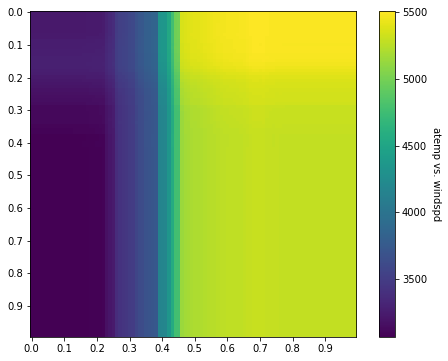

In [21]:
S_atemp_wind = np.zeros(11)
S_atemp_wind[8] = 1
S_atemp_wind[10] = 1
x_range = np.arange(0, 100, 10)
x_labels = np.round(np.arange(0, 1, .1), 2)
x_ticks = (x_range, x_labels)
two_var_plt(model, X_train, Y_train, S_atemp_wind, (0, 1), (0, 1), .01, .01, x_ticks, x_ticks, "atemp vs. windspd", 100)

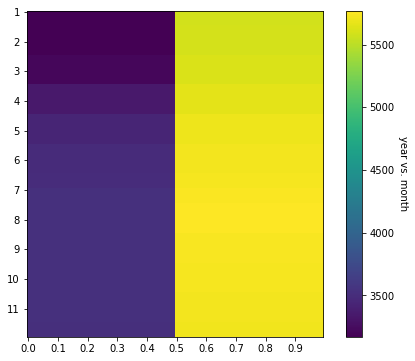

In [41]:
S_month_year = np.zeros(11)
S_month_year[1] = 1
S_month_year[2] = 1
x_range = np.arange(0, 100, 10)
x_labels = np.round(np.arange(0, 1, .1), 2)
x_ticks = (x_range, x_labels)
y_range = np.arange(0, 110, 10)
y_labels = np.round(np.arange(1, 12, 1), 2)
y_ticks = (y_range, y_labels)
two_var_plt(model, X_train, Y_train, S_month_year, (0, 1), (1, 12), .01, .1, x_ticks, y_ticks, "year vs. month", 100)